We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time we've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

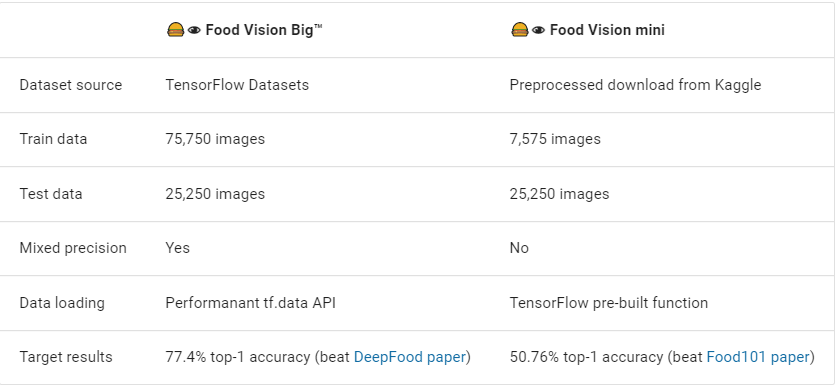

### Check GPU

We're going to be using mixed precision training.

Mixed precision training was introduced in TensorFlow 2.4.0 (a very new feature at the time of writing).

What does mixed precision training do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fd3a8bdd-91eb-6a66-6e83-a10fad94ba6a)


In [2]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.9.2


### Get helper functions

In [3]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2022-12-26 02:15:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-26 02:15:14 (94.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the Food101 dataset) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through TensorFlow Datasets (TFDS).

What is TensorFlow Datasets?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

1. Load data already in Tensors
2. Practice on well established datasets
3. Experiment with differet data loading techniques (like we're going to use in this notebook)
4. Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

1. The datasets are static (they don't change, like your real-world datasets would)
2. Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias tfds.

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True



Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the tfds.load() method.

In particular, we'll have to pass it a few parameters to let it know what we're after:

1. name (str) : the target dataset (e.g. "food101")
2. split (list, optional) : what splits of the dataset we're after (e.g. ["train", "validation"])

the split parameter is quite tricky. See the documentation for more.

3. shuffle_files (bool) : whether or not to shuffle the files on download, defaults to False
4. as_supervised (bool) : True to download data samples in tuple format ((data, label)) or False for dictionary format
5. with_info (bool) : True to download dataset metadata (labels, number of samples, etc)

In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete5JC3TY/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete5JC3TY/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "dataset_info" variable (by using the as_supervised=True parameter in the tfds.load() method, note: this will only work for supervised datasets in TFDS).

We can access the class names of a particular dataset using the dataset_info.features attribute and accessing names attribute of the the "label" key.

In [8]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

#### Exploring the Food101 data from TensorFlow Datasets

Let's find out a few details about our dataset:

1. The shape of our input data (image tensors)
2. The datatype of our input data
3. What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
4. Do the labels match up with the class names?

To do, let's take one sample off the training data (using the .take() method) and explore it.

In [10]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)


Because we used the as_supervised=True parameter in our tfds.load() method above, data samples come in the tuple format structure (data, label) or in our case (image_tensor, label).

In [11]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 77
  Class name (str form): pork_chop
        



Because we set the shuffle_files=True parameter in our tfds.load() method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

In [13]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)


Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type unit8.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

#### Plot an image from TensorFlow Datasets

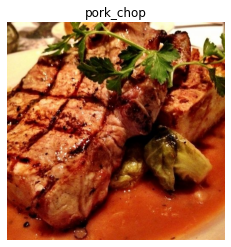

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

### Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method tf.keras.utils.image_dataset_from_directory() to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

1. In uint8 data type
2. Comprised of all differnet sized tensors (different sized images)
3. Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

1. In float32 data type
2. Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
3. Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a preprocess_img() function which:

1. Resizes an input image tensor to a specified size using tf.image.resize()
2. Converts an input image tensor's current datatype to tf.float32 using tf.cast()

🔑 Note: Pretrained EfficientNetBX models in tf.keras.applications.efficientnet (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "preprocess_img()" function (like the one below) or within your model as a tf.keras.layers.Rescaling layer.

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


Our preprocess_img() function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure (image, label).

Let's try our function out on a target image.

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


The input image gets converted from uint8 to float32 and gets reshaped from its current shape to (224, 224, 3).

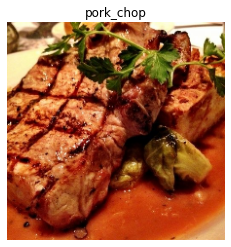

In [18]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Batch & prepare datasets

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the tf.data API.

Specifically, we're going to be using:

1. map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
2. shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
3. batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
4. prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
5. Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:

1. Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our preprocess_img() function)
2. shuffle() keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
4. For methods with the num_parallel_calls parameter available (such as map()), setting it tonum_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed
5. Can't use cache() unless your dataset can fit in memory

We're going to through things in the following order:

Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset

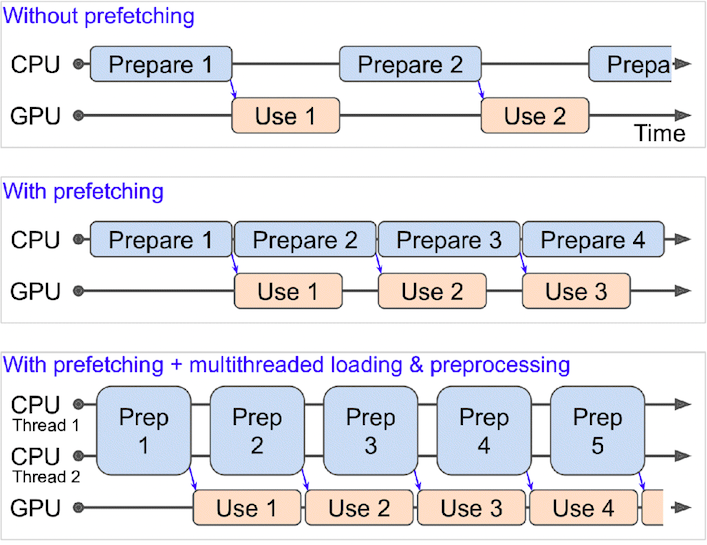

In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)


Excellent! Looks like our data is now in tutples of (image, label) with datatypes of (tf.float32, tf.int64), just what our model is after.

### Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

1. tf.keras.callbacks.TensorBoard() - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from helper_functions.py as create_tensorboard_callback())
2. tf.keras.callbacks.ModelCheckpoint() - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it

Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [21]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

### Setup mixed precision training

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as single-precision floating-point format. The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means half-precision floating-point format. And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

https://www.tensorflow.org/guide/mixed_precision

The beautiful thing is, the tensorflow.keras.mixed_precision API has made it very easy for us to get started.

First, we'll import the API and then use the set_global_policy() method to set the dtype policy to "mixed_float16".

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision


Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the mixed_precision.global_policy() method.

In [23]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

### Build feature extraction model

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

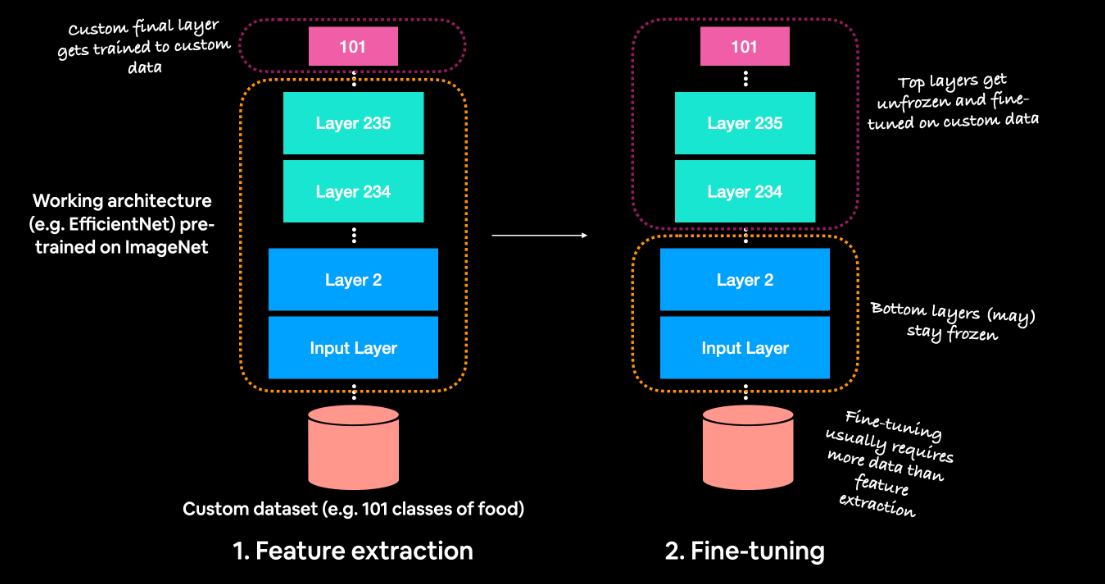

To build the feature extraction model (covered in Transfer Learning in TensorFlow Part 1: Feature extraction), we'll:

1. Use EfficientNetB0 from tf.keras.applications pre-trained on ImageNet as our base model

We'll download this without the top layers using include_top=False parameter so we can create our own output layers

2. Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
3. Put together the input, base model, pooling and output layers in a Functional model
4. Compile the Functional model using the Adam optimizer and sparse categorical crossentropy as the loss function (since our labels aren't one-hot encoded)
5. Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

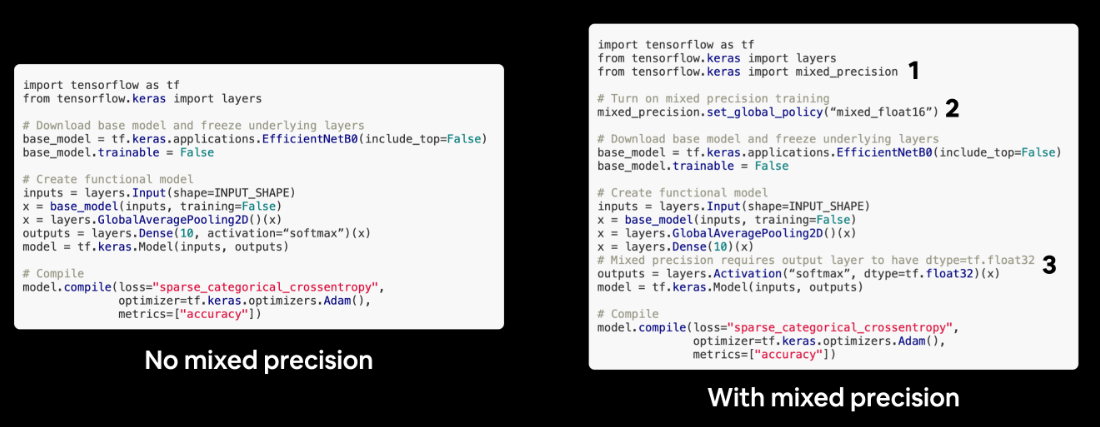

In [29]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

TypeError: ignored

In [ ]:
# Check out our model
model.summary()

### Checking layer dtype policies (are we using mixed precision?)

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's "mixed_float16").

We can check this by iterating through our model's layers and printing layer attributes such as dtype and dtype_policy.

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

Going through the above we see:

1. layer.name (str) : a layer's human-readable name, can be defined by the name parameter on construction
2. layer.trainable (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
3. layer.dtype : the data type a layer stores its variables in
4. layer.dtype_policy : the data type a layer computes in

We can also check the same details for our model's base model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

### Fit the feature extraction model

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

### Load and evaluate checkpoint weights

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using tf.keras.models.clone_model() to make a copy of our feature extraction model with reset weights.
2. Calling the load_weights() method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling evaluate() on the cloned model with loaded weights.

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

In [ ]:

# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)


Our cloned model with loaded weight's results should be very close to the feature extraction model's results (if the cell below errors, something went wrong).

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close


Cloning the model preserves dtype_policy's of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning with the cloned model, we could and it would still use the mixed precision dtype policy.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

### Save the whole model to file

We can also save the whole model using the save() method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
# model.save(save_dir)


We can also save it directly to our Google Colab instance.

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)


And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)


Loading a SavedModel also retains all of the underlying layers dtype_policy (we want them to be "mixed_float16").

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

### Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model


Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting base_model.trainable=False but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):

The input layer
The pre-trained base model layer (tf.keras.applications.EfficientNetB0)
The pooling layer
The fully-connected (dense) layer
The output softmax activation (with float32 dtype)
Therefore to inspect our base model layer, we can access the layers attribute of the layer at index 1 in our model.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy "mixed_policy16" is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

### A couple more callbacks

Luckily, there's a solution: the EarlyStopping callback.

The EarlyStopping callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combined with the ModelCheckpoint callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's val_loss.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

If you're planning on training large models, the ModelCheckpoint and EarlyStopping are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: **ReduceLROnPlateau**.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the ReduceLROnPlateau callback helps to tune the learning rate for you.

Like the ModelCheckpoint and EarlyStopping callbacks, the ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

To do this we'll create an instance of the ReduceLROnPlateau callback to monitor the validation loss just like the EarlyStopping callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7.

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Let's make sure we save our model before we start evaluating it.

In [ ]:
# # Save model to Google Drive (optional)
# loaded_gs_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

### Download fine-tuned model from Google Storage

In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()


Finally, we can evaluate our model on the test data (this requires the test_data variable to be loaded.

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

### View training results on TensorBoard

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
#   --one_shot

In [ ]:
# View past TensorBoard experiments
# !tensorboard dev list

In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
# !tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ